In [1]:
# this code isolates PSF volumes out of z-stack and then averages them
# PSFs are detected using TrackPy, the resulting locations are used to crop out the PSF volumes
# the centers of the psfs in XY are refined by chosing the slice with max intensity and perfoming a 2D gauss fit.
# the stack is then upsampled by a factor, and in XY the pixel closest to the gaussian fit is chosen. Next the
# intensity in Z along that pixel is plotted and fitted with a gauss to obtain the Z center of the PSF.
# lastly the upsampled PSFs are averaged resulting in a volume containing the average PSF.

# To add: option for overlay of gauss positions and trackpy in focus image

from pathlib import Path
import pandas as pd
import numpy as np
import trackpy as tp

import pylab
import matplotlib._pylab_helpers
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

import pims, PIL, tifffile, time, pathlib, os, json, math, glob
from pims import FramesSequence, Frame

import scipy
from scipy.ndimage import zoom
from scipy.ndimage import rotate
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

from math import floor
from mpl_toolkits.mplot3d import Axes3D

DEBUG = False

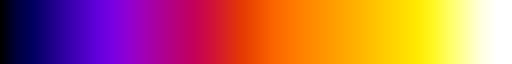

In [2]:
from psf_extractor.util import get_Daans_special_cmap

fire = get_Daans_special_cmap()
fire

In [3]:
class TiffFilePages(FramesSequence):
    def __init__(self, filename):
        self._filename = filename
        tif = tifffile.TiffFile(filename)
        self._len =  len(tif.pages)
        page = tif.pages[0]
        self._frame_shape = page.shape    
        self._dtype = page.dtype
        
    def get_frame(self, i):
        img = tifffile.imread(self._filename, key=i)
        return Frame(img, frame_no=i)

    def __len__(self):
         return self._len

    @property
    def frame_shape(self):
         return self._frame_shape

    @property
    def pixel_type(self):
         return self._dtype

def super_gaussian(x, x0, sigma, amp, back, rank):
        return amp * ((np.exp(-(2 ** (2 * rank - 1)) * np.log(2) * (((x - x0) ** 2) / ((sigma) ** 2)) ** (rank))) ** 2) + back

In [4]:
def gaussian_2D(x, y, x0, y0, xalpha, yalpha, theta, A, B): #define 2D gauss function
    theta = np.deg2rad(theta)
    a = np.cos(theta)**2/(2*xalpha**2) + np.sin(theta)**2/(2*yalpha**2)
    b = -1*np.sin(2*theta)/(4*xalpha**2) + np.sin(2*theta)/(4*yalpha**2)
    c = np.sin(theta)**2/(2*xalpha**2) + np.cos(theta)**2/(2*yalpha**2)
    return A * np.exp( -(a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2)) + B

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian_2D(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//7):
        arr += gaussian_2D(x, y, *args[i*7:i*7+7])
    return arr

def do_2D_gauss_fit(arr, thetaest=45):
    arry, arrx = arr.shape
    midx, midy, sigx, sigy, maxI, minI = gauss2D_param(arr)
    p0 = [midx, midy, sigx/4, sigy, thetaest, maxI, minI]
    x, y = np.arange(0, arrx), np.arange(0, arry)
    X, Y = np.meshgrid(x, y)
    xdata = np.vstack((X.ravel(), Y.ravel()))
    popt, pcov = curve_fit(_gaussian_2D, xdata, arr.ravel(), p0, maxfev = 8000)
    return popt #give back all fit values
    
def gaussian_1D(x, x0, xalpha, A, B): 
    return A * np.exp( -((x-x0)**2 / (2*xalpha**2))) + B

def gauss2D_param(im): #estimate first guesses for parameters
    imy, imx = im.shape
    for fact in [3, 2.5, 2, 1.5, 1, 0.5]:
        try:
            image = im.copy()
            idxs = image < image.mean() + fact*image.std()
            idxs = scipy.ndimage.binary_dilation(idxs)
            image[idxs] = 0
            xy = np.argwhere(image > 0)
            ys, xs = xy[:,0], xy[:,1]
            midy, midx = ys.mean(), xs.mean()
            sigy, sigx = (ys.max() - ys.min())/2, (xs.max() - xs.min())/2
            yn, yp = intround(midy-sigy), intround(midy+sigy)
            xn, xp = intround(midx-sigx), intround(midx+sigx)
            maxI = image[yn:yp, xn:xp].mean()*2
            minI = im.mean()
            return midx, midy, sigx, sigy, maxI, minI
        except:
            if DEBUG:
                print(str(fact)+" failed:", im.mean(), fact*im.std())
    return imx//2, imy//2, 5, 5, im.max(), im.min()

def gauss1D_param(ydata):
    for fact in [2, 1.5, 1, 0.5,0.25]:
        try:
            yd = ydata.copy()
            idxs = yd < yd.mean() + fact*yd.std()
            idxs = scipy.ndimage.binary_dilation(idxs)
            yd[idxs] = 0
            xs = np.argwhere(yd > 0)
            if xs.size < 1: raise #check if list is empty
            midx = xs.mean()
            sigx = (xs.max() - xs.min())/2
            xn, xp = intround(midx-sigx), intround(midx+sigx)
            if yd[xn:xp].size < 1: raise #check if list is empty
            maxI = yd[xn:xp].mean()*2
            minI = ydata.mean()
            if np.isnan(maxI) or sigx <0.5: raise
            if DEBUG: 
                print("zprof ", str(fact)+" success:", ydata.mean(), fact*ydata.std())
            return midx, 2*fact*sigx, maxI, minI
        except:
            if DEBUG:
                print("zprof ", str(fact)+" failed:", ydata.mean(), fact*ydata.std())
    return int(len(ydata)/2), 5, max(ydata), min(ydata)

def do_1D_gauss_fit(ydata, xdata=None):
    if type(xdata) == type(None): xdata = np.arange(0, len(ydata))
    midx, sigx, maxI, minI = gauss1D_param(ydata)
    p0 = [xdata[intround(midx)], np.abs(xdata[1]-xdata[0])*sigx, maxI, minI]
    popt, pcov = curve_fit(gaussian_1D, xdata, ydata, p0, maxfev = 8000)
    xfine = np.linspace(xdata.min(), xdata.max(), len(xdata)*5)
    return popt, xfine, xdata

In [5]:
class HaltException(Exception): pass

def check_blacklist(features, widths, dims):
    blacklist = np.zeros(len(features)) # create array to keep track of overlap
    if set(widths) != set(dims): raise HaltException("Keys not equal in passed widths and dims dictionaries")
    axis = [key for key in dims.keys() if key in features.columns.values]
    for i in features.index: # run over all particles in zstack
        if blacklist[i]==0: #check if particles is already blacklisted
            for key in axis:
                p_i = round(features[key][i],0)
                if p_i < widths[key] or p_i > dims[key]-widths[key]:
                    blacklist[i]=1
                    break
            if blacklist[i] == 1: continue  
            #check for overlap
            for j in features.index:
                if i != j:  # omit comparing particle to itself
                    bools = []
                    for key in axis:
                        p_i = round(features[key][i],0)
                        p_j = round(features[key][j],0)
                        bools.append(bool(abs(p_j-p_i) < 2*widths[key]))
                    if np.all(bools):
                        blacklist[i]=2
                        blacklist[j]=2
    if sum(blacklist) == len(features): raise HaltException("All PSFs overlap or are too close to box edge, choose smaller PSF volume...")
    return blacklist

In [6]:
glob = '../data/sample_zstack_png_sequence/*.png'
pims.open(glob)

<Frames>
Source: M:\tnw\ist\do\projects\iCAT\development\PSF-Extractor\data\sample_zstack_png_sequence\*.png
Length: 32 frames
Frame Shape: (2048, 2448)
Pixel Datatype: uint8

In [7]:
def get_stack(loc, fn, c_outdir=True):
    outd = "_output"
    if not loc[-1] in ["/", "\\"]: 
        loc += "/"
    if "*.png" in fn or "*.tif" in fn:
        stack = pims.open(loc + fn) 
        # if this crashes on plugin keyword -> install pims from git master
        stack.__dict__['_filename'] = stack.pathname
    elif ".tif" in fn:
        stack = pims.TiffStack(loc + fn)
        outd = pathlib.Path(stack._filename).stem + outd
        if len(stack) < 2:
            # PIMS fails to get full stack, retry with tifffile
            stack = TiffFilePages(loc + fn)
    else: raise HaltException("Did not correctly specify files using .tif or *.png")
    outdir = os.path.join(os.path.dirname(stack._filename), outd)
    if not os.path.exists(outdir) and c_outdir: os.makedirs(outdir)
    return outdir, stack
                    
def get_pb(flt):
    return flt - floor(flt)

In [8]:
def plot_debug(max_proj, features, features_filt, locs, width_x, width_y, filt_psfs):
    fig = plt.figure(dpi=300)
    imy, imx = max_proj.shape
    spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, 
                             height_ratios=[1,1,1,1],
                             width_ratios=[1,1]) 
    spec2 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, 
                              height_ratios=[1,1,1],
                              wspace=0.1, hspace=0.4,
                              width_ratios=[1,0.4, 0.4])
    ax1 = fig.add_subplot(spec[0:2,0])
    plt.imshow(max_proj, cmap=fire)
    plt.plot(features.x.values, 
             features.y.values,
             'o', markerfacecolor='None', 
             markersize=10, 
             markeredgecolor="red")
    ax1.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False  # labels along the bottom edge are off)
                    )
    plt.ylabel("Y [px]", fontsize=7)

    ax2 = plt.subplot(spec[2:,0])
    plt.imshow(max_proj, cmap=fire)
    plt.plot(features_filt.x.values, 
             features_filt.y.values, 
             'o', markerfacecolor='None', 
             markersize=10, 
             markeredgecolor="red")
    plt.xlabel("X [px]", fontsize=7)
    plt.ylabel("Y [px]", fontsize=7)

    ax3 = fig.add_subplot(spec2[0,1:])
    nbins = intround((features['mass'].max() - features['mass'].min()))
    if nbins == 0: nbins = 30
    plt.hist(features['mass'], bins=nbins)
    nbins = intround((features_filt['mass'].max() - features_filt['mass'].min()))
    if nbins == 0: nbins = 30
    plt.hist(features_filt['mass'], bins=nbins)

    plt.grid(True)
    plt.xlabel("Mass [a.u.]", fontsize=6)
    plt.axvline(features_filt.mass.min(), c='r')
    plt.axvline(features_filt.mass.max(), c='r')
    ax4 = fig.add_subplot(spec2[2,1])
    plt.hist(locs.pb_x_tp)
    plt.grid()
    plt.hist(locs.pb_x_g)
    plt.xlabel("X Pixel bias [px]", fontsize=6)
    ax5 = fig.add_subplot(spec2[1,1])
    plt.hist(locs.pb_y_tp)
    plt.hist(locs.pb_y_g)
    plt.grid()
    plt.xlabel("Y Pixel bias [px]", fontsize=6)

    ax6 = fig.add_subplot(spec2[2,2], sharey=ax4)
    xtp = [get_pb(x) for x in features.x.values]
    plt.hist(xtp)
    plt.grid()
    plt.xlabel("X Pixel bias [px]", fontsize=6)
    ax6.tick_params(axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,      # ticks along the bottom edge are off
                    labelleft=False  # labels along the bottom edge are off)
                    )
    ax7 = fig.add_subplot(spec2[1,2], sharey=ax5, sharex=ax5)
    ytp = [get_pb(x) for x in features.y.values]
    plt.hist(ytp)
    plt.grid()
    plt.xlabel("Y Pixel bias [px]", fontsize=6)
    set_ax_ticksize([ax1,ax2, ax3, ax4, ax5, ax6, ax7], fontsize=6)
    ax7.tick_params(axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,      # ticks along the bottom edge are off
                    labelleft=False  # labels along the bottom edge are off)
                    )
    plt.tight_layout()
    
    total = len(filt_psfs)
    xy = math.ceil(np.sqrt(total))
    fig, axes = plt.subplots(nrows=xy, ncols=xy, sharex=True, sharey=True, dpi=300, figsize=(10,10))
    for i, ax in enumerate(axes.flat):
        if i < total:
            im = ax.imshow(max_int_proj(filt_psfs[i]), cmap=fire)
            set_ax_ticksize(ax)
            ax.set_title(locs.PSF[i])
        else:
            ax.set_axis_off()
        #im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)
    plt.suptitle("Maximum Intensity Projection for selected beads")
    plt.tight_layout(rect=[0, 0.02, 1, 0.97])
    cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    plt.colorbar(im, cax=cax, **kw)

In [9]:
def plot_PSF(psf_sum, pi_x, pi_y, pi_z):
    sumz, sumy, sumx = psf_sum.shape
    focim, (zpos, ypos, xpos) = psf_gauss_fit(psf_sum)
    
    plt.imsave("focim.tiff", focim)
    zpos, ypos, xpos = intround(zpos), intround(ypos), intround(xpos)
    fig = plt.figure(figsize=(8,8), dpi=300)
    spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, 
                             width_ratios=[sumx * pi_x, sumz * pi_z], 
                             height_ratios=[sumx * pi_x, *[sumz * pi_z/4]*3], )
    spec2 = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, 
                             width_ratios=[sumx * pi_x, sumz * pi_z], 
                             height_ratios=[sumx * pi_x, *[sumz * pi_z/4]*3], 
                             hspace=0.1)
    ax1 = fig.add_subplot(spec[0])
    plt.imshow(psf_sum[zpos,:,:], interpolation=interp, cmap=fire, 
               extent=[sumx//2 * pi_x / -1e3, sumx//2 * pi_x / 1e3,
                       sumx//2 * pi_x / -1e3, sumx//2 * pi_x / 1e3])
    ax1.annotate("XY", xy=(50/(sumx * pi_x), 50/(sumx * pi_x)), 
                 xycoords="axes fraction", color='white', weight='semibold',
                fontsize=11)
    plt.xlabel(r"X [$\mathrm{\mu m}$]")
    plt.ylabel("Y [$\mathrm{\mu m}$]")
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 

    ax2 = plt.subplot(spec[1:,0], sharex = ax1)
    plt.imshow(psf_sum[:,ypos,:], interpolation=interp, cmap=fire, 
               extent=[sumx//2 * pi_x / -1e3, sumx//2 * pi_x / 1e3, 
                       sumz//2 * pi_z / 1e3, sumz//2 * pi_z / -1e3])
    plt.ylabel("Z [$\mathrm{\mu m}$]")
    ax2.annotate("XZ", xy=(50/(sumx * pi_x), 50/(sumz * pi_z)), 
                 xycoords="axes fraction", color='white', weight='semibold',
                fontsize=11)
    ax2.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False  # labels along the bottom edge are off)
                    )

    ax3 = plt.subplot(spec[0,1], sharey = ax1)
    plt.imshow(np.rot90(psf_sum[:,:,xpos]), interpolation=interp, cmap=fire, 
               extent=[sumz//2 * pi_z / -1e3, sumz//2 * pi_z / 1e3, 
                       sumx//2 * pi_x / -1e3, sumx//2 * pi_x / 1e3])
    ax3.tick_params(axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,      # ticks along the bottom edge are off
                    right=False,         # ticks along the top edge are off
                    labelleft=False  # labels along the bottom edge are off)
                    )
    plt.xlabel("Z [$\mathrm{\mu m}$]")
    ax3.annotate("YZ", xy=(50/(sumz * pi_z), 50/(sumx * pi_x)), 
                 xycoords="axes fraction", color='white', weight='semibold',
                fontsize=11)
    ax3.xaxis.tick_top()
    ax3.xaxis.set_label_position('top') 

    ax4 = fig.add_subplot(spec2[3,1])
    ax5 = fig.add_subplot(spec2[2,1], sharex=ax4)
    ax6 = fig.add_subplot(spec2[1,1], sharex=ax4)

    zprof = psf_sum[:, ypos, xpos]
    xprof = psf_sum[zpos, ypos, :]
    yprof = psf_sum[zpos, :, xpos]
    zprofx = (np.arange(0, sumz) - sumz/2) * pi_z
    yprofx = (np.arange(0, sumy) - sumy/2) * pi_y
    xprofx = (np.arange(0, sumx) - sumx/2) * pi_x

    xlim = []
    for a, prof, xprof, l, c in zip([ax4, ax5, ax6], 
                                    [xprof, yprof, zprof], 
                                    [xprofx, yprofx, zprofx],
                                    ["X", "Y", "Z"],
                                    ['lime', "deepskyblue", "tomato"]):
        popt, xfine, _ = do_1D_gauss_fit(prof, xprof)

        lineval = popt[0]/1e3
        a.plot(xprof/1e3 - lineval, prof, '.', c=c, label=l)
        a.plot(xfine/1e3 - lineval, gaussian_1D(xfine, *popt), 'k-', lw=0.75,
               label=r"$\mathrm{FWHM}$"+"={:.0f} nm".format(popt[1]*2.35))
        a.tick_params(axis='y',          # changes apply to the x-axis
                      which='both',      # both major and minor ticks are affected
                      left=False,      # ticks along the bottom edge are off
                      right=True,         # ticks along the top edge are off
                      labelright=False,  # labels along the bottom edge are off)
                      labelleft=False  # labels along the bottom edge are off)
                      )
        a.tick_params(axis='x',          # changes apply to the x-axis
                      which='both',      # both major and minor ticks are affected
                      bottom=True,      # ticks along the bottom edge are off
                      top=False,         # ticks along the top edge are off
                      labelbottom=False  # labels along the bottom edge are off)
                      )
        a.yaxis.set_label_position('right') 
        a.legend(fontsize='x-small', handlelength=0.8)
        a.grid(True)
        a.set_ylim(0, None)
        xlim = np.max([xlim, 2*popt[1]*2.35+popt[0]])
        lineval = 0
        if l == "X":
            ax1.axhline(lineval, c=c, ls='--', lw = 0.75)
            ax2.axhline(lineval, c=c, ls='--', lw = 0.75)
        elif l == "Y":
            ax1.axvline(lineval, c=c, ls='--', lw = 0.75)
            ax3.axvline(lineval, c=c, ls='--', lw = 0.75)
        elif l == "Z":
            ax2.axvline(lineval, c=c, ls='--', lw = 0.75)
            ax3.axhline(lineval, c=c, ls='--', lw = 0.75)
        
    ax4.set_xlabel("Distance [$\mathrm{\mu m}$]")
    ax4.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=True  # labels along the bottom edge are off)
                    )
    
    ax5.set_ylabel("\nSignal intensity [a.u.]")
    xlim *= 1e-3
    ax4.set_xlim(-1 * xlim, xlim)

In [10]:
def multipage(filename, figs=None, dpi=300):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for i, fig in enumerate(figs):
        pngfilename = filename.replace(".pdf", "_"+str(i)+".png")
        fig.savefig(pngfilename)
        fig.savefig(pp, format='pdf')
    pp.close()
    
def round_up_to_odd(f):
    return np.ceil(f) // 2 * 2 + 1

def rup2oddint(f):
    return int(round_up_to_odd(f))

def iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

def eight_bit_as(arr, dtype=np.float32):
    if arr.dtype != np.uint8:
        arr = arr.astype(np.float32)
        arr -= arr.min()
        arr *= 255.0/arr.max()
    else:
        arr = arr.astype(np.float32)
    return arr.astype(dtype)

def max_int_proj(arr):
    return np.max(arr, axis=0)

def cut_section_from_stack(arr3d, x, y, wx, wy, z=None, wz=None, upsampled=False):
    pw = 0
    lenz, leny, lenx = arr3d.shape
    minx, maxx = int(round(x - wx)), int(round(x + wx))
    miny, maxy = int(round(y - wy)), int(round(y + wy))
    try:
        minz, maxz = int(round(z - wz)), int(round(z + wz))
    except:
        minz = 0
        maxz = lenz
    mins, nulls = (minz, miny, minx), (0, 0, 0)
    maxs, lims = (maxz, maxy, maxx), arr3d.shape
    minidxs = np.array(mins)
    maxidxs = np.array(lims) - np.array(maxs)
    if np.any(minidxs < 0) or np.any(maxidxs < 0):
        a = np.concatenate((minidxs, maxidxs), axis=None)
        a[a > 0] = 0
        pw = np.max(np.abs(a))
        arr3d = np.pad(arr3d, pw, mode='edge')
        if DEBUG:
            bla = {0:"minz", 1:"miny", 2:"minx", 3:"maxz", 4:"maxy", 5:"maxx"}
            print(bla[np.argmin(a)], "PW:", pw)
    return arr3d[minz+pw:maxz+pw, miny+pw:maxy+pw, minx+pw:maxx+pw]

def psf_z_gauss_fit(arr, x=None, y=None):
    arrz, arry, arrx = arr.shape
    if not x or not y:
        x, y = arrx//2, arry//2
    else:
        x, y = intround(x), intround(y)
    z_profile = arr[:,x, y]
    xdata = np.arange(0, arrz)
    popt, xfine, _ = do_1D_gauss_fit(z_profile, xdata)
    return popt

def psf_gauss_fit(arr):
    centerpos = []
    if len(arr.shape) > 2: #3D stack
        arrz, arry, arrx = arr.shape
        mip = max_int_proj(arr)
        xgp, ygp, _, _, _, _, _ = do_2D_gauss_fit(mip)
        pz = psf_z_gauss_fit(arr, xgp, ygp)
        zgp = pz[0]
        centerpos.append(zgp)
        focim = arr[intround(zgp), :, :]
    else: focim = arr
    x_gp, y_gp, x_si, y_si, rot, maI, miI = do_2D_gauss_fit(focim)
    centerpos.append(y_gp)
    centerpos.append(x_gp)
    if len(arr.shape) > 2:
        #if np.abs(x_gp - xgp) > 1 or np.abs(y_gp - ygp) > 1:
            pz = psf_z_gauss_fit(arr, x_gp, y_gp)
            centerpos[0] = pz[0]
    return focim, centerpos
    
def crop_and_fit(arr3d, x, y, wx, wy, z=None, wz=None):
    crop = cut_section_from_stack(arr3d, x, y, wx, wy, z, wz)
    focim, (z_gp, y_gp, x_gp) = psf_gauss_fit(crop)
    x = x - wx + x_gp
    y = y - wy + y_gp
    try:
        z = z - wz + z_gp
    except: 
        z = z_gp
    cropstack = cut_section_from_stack(arr3d, x, y, wx, wy, z, wz)
    z_corr = (arr3d.shape[0] - cropstack.shape[0])//2
    return cropstack, focim, x_gp, y_gp, z_gp-z_corr, x, y, z

def rebin(arr, factor):
    shape = [arr.shape[0] // factor, factor,
             arr.shape[1] // factor, factor]
    mean_axis = (1,3)
    if arr.ndim == 3:
        shape = np.append(shape, [arr.shape[2] // factor, factor])
        mean_axis += (5,)
    return arr.reshape(shape).mean(mean_axis)

def intround(f):
    return  int(round(f,0))

def set_ax_ticksize(ax, fontsize=8):
    if not type(ax) == type([]): ax = [ax]
    for a in ax:
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
        for tick in a.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize)

In [11]:
#set pixel size in nm:
pixel_z = 125.
pixel_x = 34.5 
pixel_x = 64.
pixel_y = pixel_x

#Trackpy minimum mass for max intensity projection
#max_proj_mm = 1000
#Trackpy diameter z, y, x in nm
tpyd = [1500, 800, 800] 

#upsampling factor
upsampling_factor = 6 #even if possible
interp = "none"
extra_xy_width = 5

#set psf cutout size in um
xy_width = 2 
z_width = 2

#plot overlay of trackpy coordinates and gauss fit on image (XY, XZ and YZ)??
plot = False
plot_tp = False
DEBUG = False

#load image stack 
location = '../data//'
fns = ["sample_zstack_png_sequence/*.png"]

In [20]:
psf  # this is actually the substack, right?

array([[[1., 0., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [2., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 0.]],

       [[1., 0., 1., ..., 2., 1., 1.],
        [1., 1., 0., ..., 1., 1., 2.],
        [1., 1., 1., ..., 2., 2., 2.],
        ...,
        [0., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 0., 1., ..., 1., 1., 2.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 0., ..., 1., 0., 0.],
        [1., 0., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [2., 1., 1., ..., 1., 0., 1.],
        ...,
        [1., 1., 0., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1.

In [26]:
focim, x_gp, y_gp, z_gp, x_ori, y_ori, z_ori

(array([[1., 0., 0., ..., 0., 1., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 36.319445587595766,
 36.33414038691645,
 14.29188309857151,
 1408.3194455875957,
 1457.3341403869165,
 14.29188309857151)

Processing sample_zstack_png_sequence/*.png...
Load new stack
Locating features with different min_mass


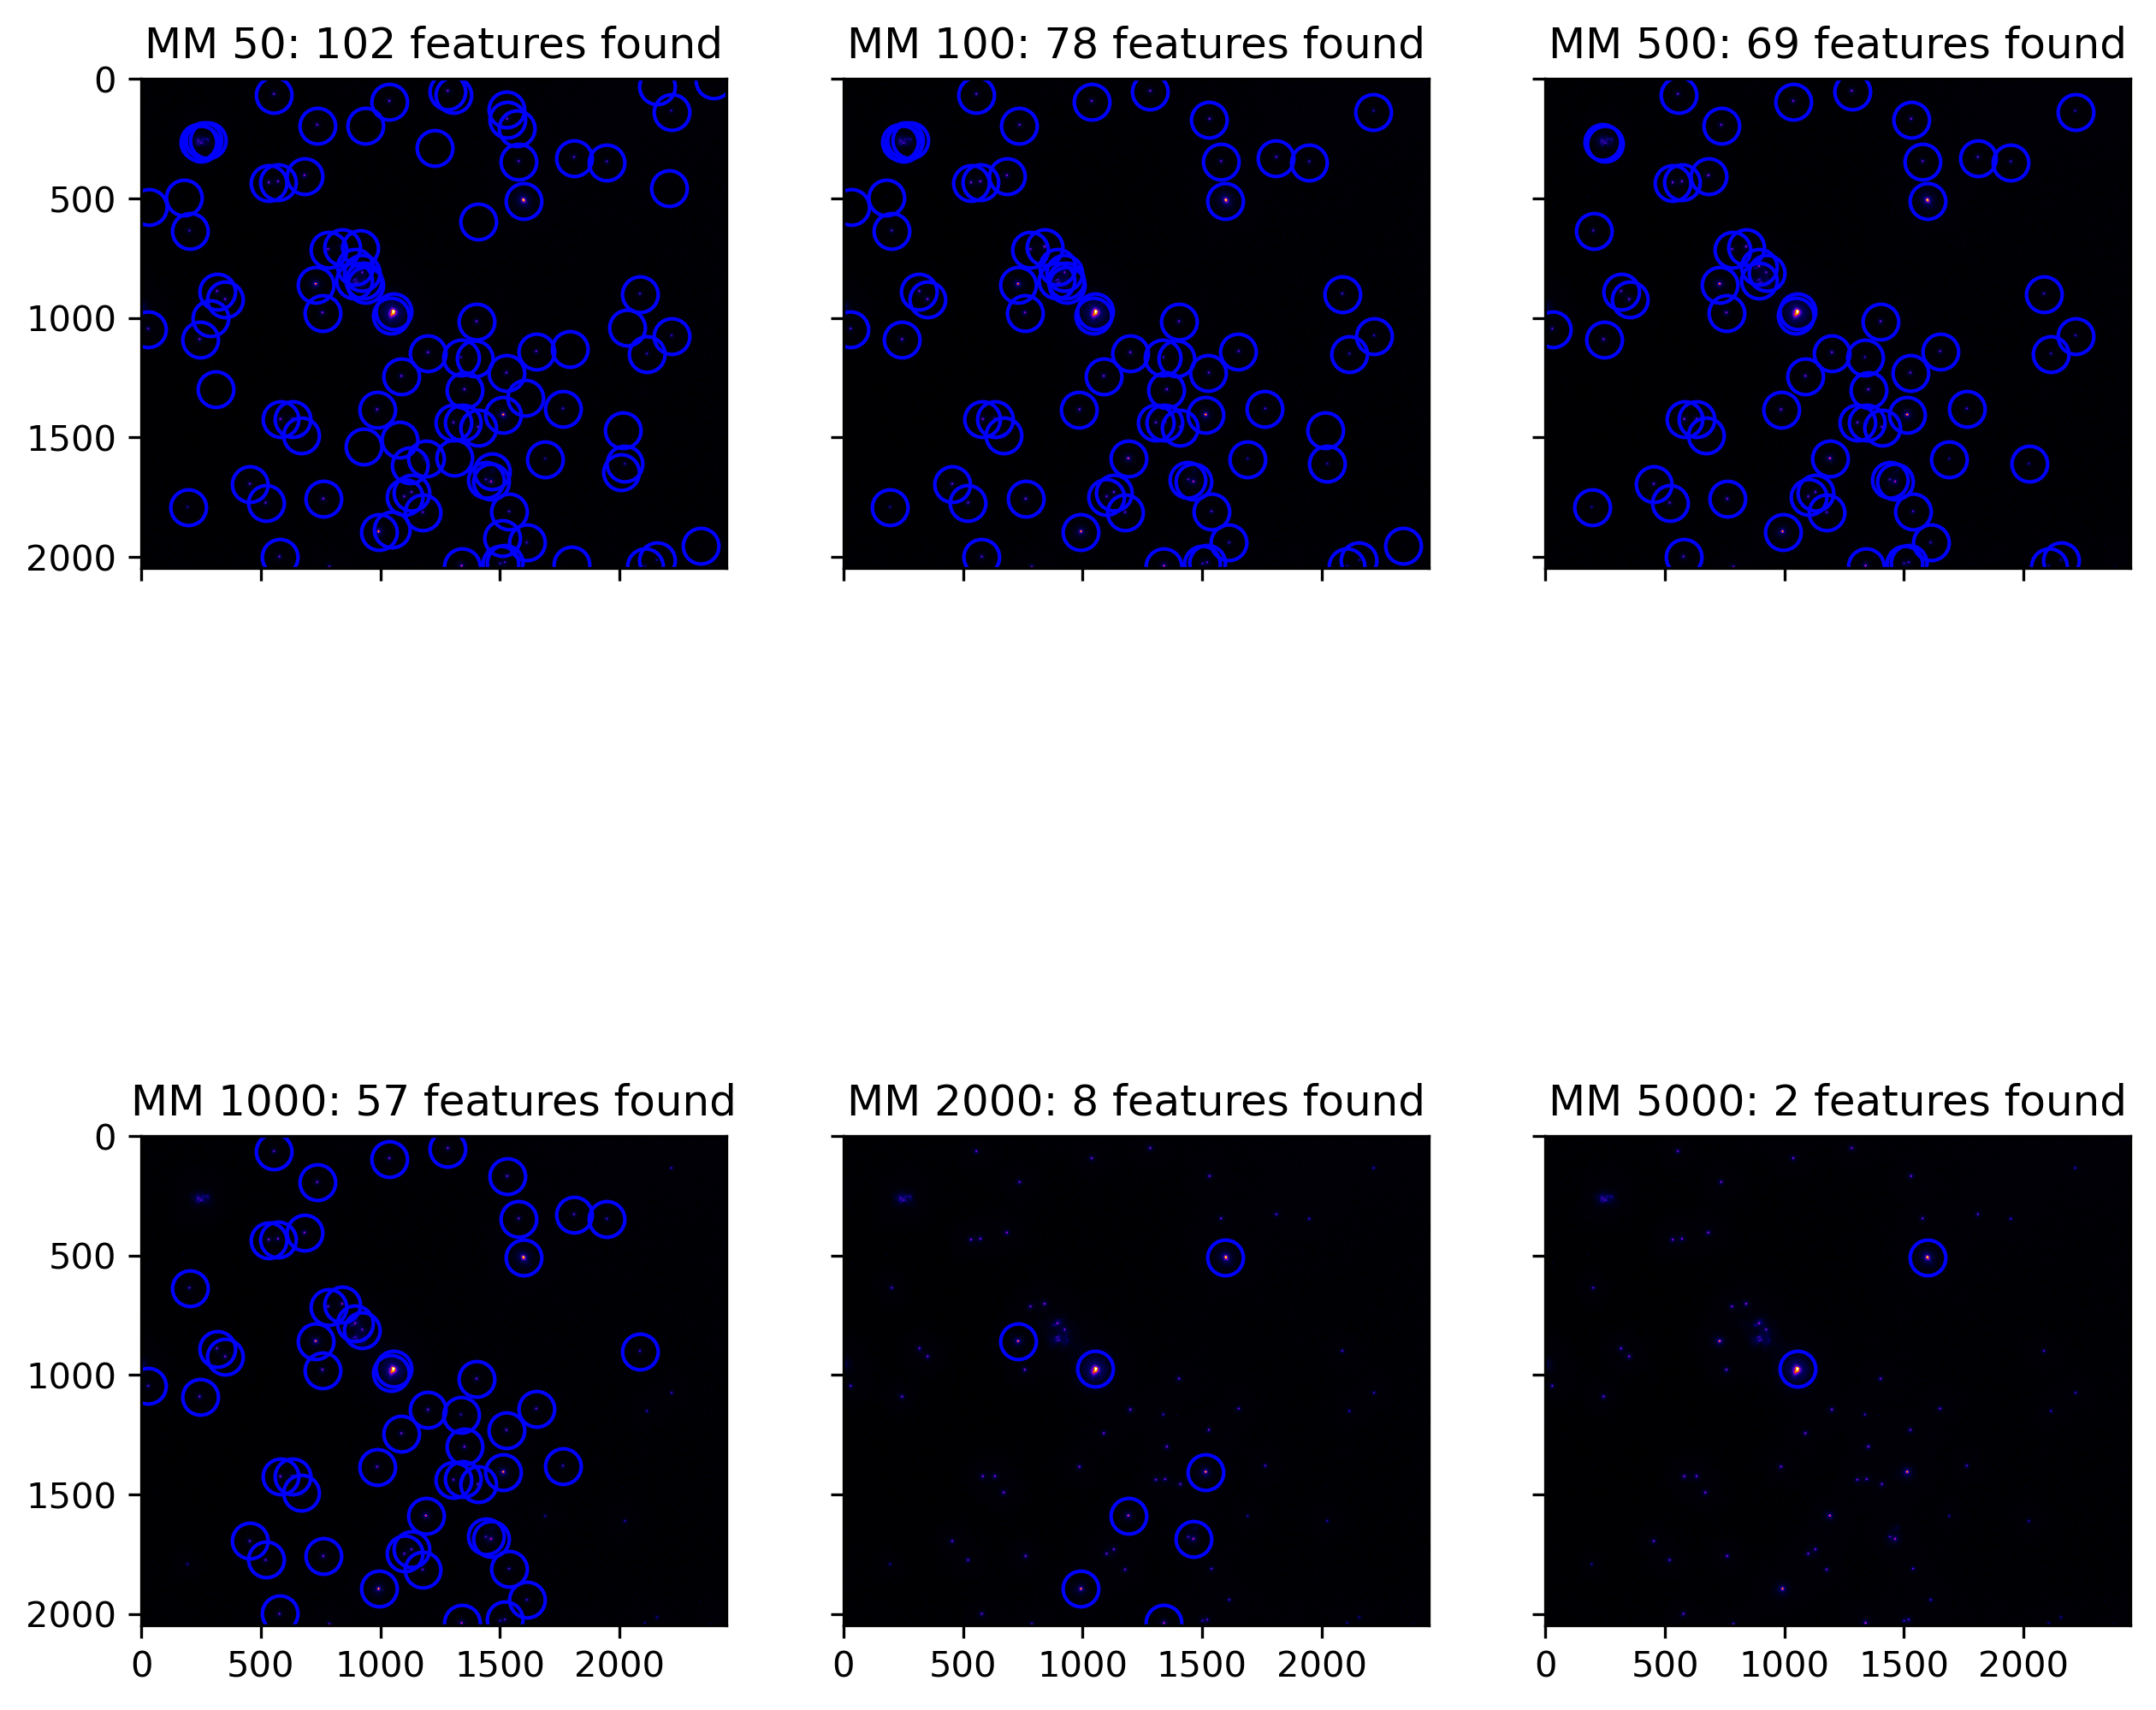

Select minmass (integer number):  750


Locating features with minmass: 750
Extracting PSFs from stack:
********************
Filter PSFs...


In [21]:
for file_name in fns:
    print("Processing", file_name+"...")
    start = time.time()
    if "/*.png" not in file_name and ".tif" not in file_name: file_name += "/*.png"
    try:
        vars = json.load(open(location+"/"+file_name[:-5]+"parameters.json", 'r'))
        pixel_z = vars['focusstep'] * 1e3
        pixel_x = vars['pixelsize'] * 1e3
        pixel_y = pixel_x
    except:
        pass

    #cutout widths in pixels
    width_x = int(xy_width * 1e3 / pixel_x)
    width_y = width_x
    width_z = int(z_width * 1e3 / pixel_z)
    widths = {"x":width_x, "y":width_y, "z":width_z}

    #trackpy diameter
    tpy_diameter = [rup2oddint(dia/px) for dia, px in zip(tpyd, [pixel_z, pixel_y, pixel_x])]
    
    #load stack if new filename
    try: 
        new_stack_bool = os.path.normpath(stack._filename) == os.path.normpath(location + file_name)
    except NameError: new_stack_bool = False
    if not new_stack_bool:
        print("Load new stack")
        outdir, stack = get_stack(location, file_name)
        stack_arr = np.array(stack)
        stack_arr = eight_bit_as(stack_arr)
        max_proj = max_int_proj(stack_arr)
        max_proj -= max_proj.min()
        max_proj *= 255.0/max_proj.max()
        
        print("Locating features with different min_mass")
        fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, dpi=300, figsize=(10,10))
        for (ax, mm) in zip(axes.flat, [50, 100, 500, 1000, 2000, 5000]):
            features = tp.locate(max_proj, diameter=tpy_diameter[1:], 
                                     minmass=mm)
            features.reset_index(drop=True, inplace=True)
            ax.imshow(max_proj, cmap=fire)
            ax.plot(features.x.values, features.y.values,
                     'o', markerfacecolor='None', 
                     markersize=10, 
                     markeredgecolor="blue")
            ax.set_title("MM "+str(mm)+": "+str(len(features))+" features found")
        plt.show()
        max_proj_mm = int(input("Select minmass (integer number): "))
    else: print("Using preloaded stack")
    
    print("Locating features with minmass: {}".format(max_proj_mm))
    features = tp.locate(max_proj, diameter=tpy_diameter[1:], 
                             minmass=max_proj_mm)
    
    features.reset_index(drop=True, inplace=True)
  
    #determine max dimensions z-stack
    stack_shape = np.shape(stack_arr)
    dims = {"x":stack_shape[2], "y":stack_shape[1], "z":stack_shape[0]}

  
    #Leave out particles too close to each other (set by width of cutout)
    blacklist = check_blacklist(features, widths, dims)

    #Filter featurellist
    idxs = [i for i in range(len(features)) if blacklist[i] != 0]
    features_filt = features.drop(features.index[idxs])

    #Select on mass
    lenmass = len(features_filt)
    if lenmass > 12: lenmass /= 2
    features_filt = features_filt.sort_values('mass').head(n=int(lenmass)).reset_index()

    if len(features_filt) == 0: raise HaltException("All {} features blacklisted and disqualified: change widths".format(len(features)))

    #make array to save locations of psf
    locations = [] # PSF#, x, y, z, pb_x_tp, pb_y_tp, pb_x_g, pb_y_g, pb_z_g

    locs = pd.DataFrame(locations, columns = ["PSF", "x", "y", "z", 
                                              "pb_x_tp", "pb_y_tp", 
                                              "pb_x_g", "pb_y_g", "pb_z_g"])
    
    #loop over all filtered beads
    work_stack = stack_arr.copy()
    psf_sum, singlets = None, []
    print("Extracting PSFs from stack:")
    for i, (j, row) in enumerate(features_filt.iterrows()):
        y = round(row.y,0) #y
        x = round(row.x,0) #x
        try:
            cropped = crop_and_fit(work_stack, 
                               x, 
                               y, 
                               width_x+extra_xy_width, 
                               width_y+extra_xy_width)
        except:
            #features_filt.drop(features_filt.index[i], inplace=True)
            continue
        else:
            psf, focim, x_gp, y_gp, z_gp, x_ori, y_ori, z_ori = cropped
            
        #save psf volume to file
        filepath = outdir + "/psf_{}.tif".format(j)
        singlets.append("/psf_{}.tif".format(j))
        tifffile.imwrite(filepath, psf, photometric='minisblack')

        # save location of psf to array
        loc = [i, x_ori, y_ori, z_ori, x_gp, y_gp, z_gp,
               get_pb(row.x), get_pb(row.y),
               get_pb(x_gp), get_pb(y_gp), get_pb(z_gp),
              ]
        locations.append(loc)
        print("*"*(i+1) + "-"*(len(features_filt)-i-1), end='\r')
    
    print("\nFilter PSFs...")
    refs = np.random.randint(0,len(singlets),5)
    pss = []
    for j, ref in enumerate(refs):
        _, psf0 = get_stack(outdir, singlets[ref], c_outdir=False)
        psf0 = np.array(psf0)
        ps = []
        for i in range(0,len(singlets)):
            _, psf0 = get_stack(outdir, singlets[i], c_outdir=False)
            psf = np.array(psf)
            p, _ = scipy.stats.pearsonr(max_int_proj(psf0).ravel(), max_int_proj(psf).ravel())
            ps.append(p)
        print("*"*(int((j+1)*len(singlets)/len(refs))) + "-"*(len(singlets)-int((j+1)*len(singlets)/len(refs))), end='\r')
        pss.append(ps)
    ps = np.mean(pss, axis=0)
    psmean = np.mean(ps)
    filt_singlets = np.argwhere((psmean - 0.04 < ps) &  (ps < psmean + 0.06)).flatten()
    
#     filt_psfs, filt_locs = [], []
#     for i in filt_singlets:
#         _, psf = get_stack(outdir, singlets[i], c_outdir=False)
#         filt_psfs.append(np.array(psf))
#         filt_locs.append(locations[i])
    
#     print("\nUpsample and average PSFs:")
#     for i, (psf, loc) in enumerate(zip(filt_psfs, filt_locs)):
#         _, x_ori, y_ori, z_ori, x_gp, y_gp, z_gp, _, _, _, _, _ = loc
                                   
#         #upscale psf image stack for better overlay
#         psf_upsampled = psf.repeat(upsampling_factor, axis=0) \
#                            .repeat(upsampling_factor, axis=1) \
#                            .repeat(upsampling_factor, axis=2)
        
#         psf_upsampled = cut_section_from_stack(psf_upsampled, 
#                                                x_gp*upsampling_factor + upsampling_factor/2,
#                                                y_gp*upsampling_factor + upsampling_factor/2,
#                                                width_x*upsampling_factor, 
#                                                width_y*upsampling_factor, 
#                                                z_gp*upsampling_factor + upsampling_factor/2,
#                                                width_z*upsampling_factor,
#                                                upsampled=True)
#         if type(psf_sum) == type(None): 
#             psf_sum = psf_upsampled
#         else:
#             psf_sum = np.add(psf_sum, psf_upsampled)
#         print("*"*(i+1) + "-"*(len(filt_psfs)-i-1), end='\r')
    
#     #save psf locations to file
#     print("\nSaving PSF & metadata")
#     filepath = outdir + "/locations.csv"
#     locs = pd.DataFrame(filt_locs, columns = ["PSF", "x", "y", "z", "x_gp", "y_gp", "z_gp", 
#                                               "pb_x_tp", "pb_y_tp", 
#                                               "pb_x_g", "pb_y_g", "pb_z_g"])
#     locs.to_csv(filepath, index=False)    
   
#     binned_psf_sum = rebin(psf_sum, upsampling_factor)
#     uint8_binned_psf_sum = eight_bit_as(binned_psf_sum, np.uint8)

#     #write averaged psf to file
#     filepath = outdir + "/psf_av.tif"
#     tifffile.imwrite(filepath, uint8_binned_psf_sum, photometric='minisblack')

#     print("Generating debugging plot")
#     plot_debug(max_proj, features, features_filt, locs, width_x, width_y, filt_psfs)
    
#     print("Generating PSF")
#     plot_PSF(psf_sum, pixel_x/upsampling_factor, pixel_y/upsampling_factor, pixel_z/upsampling_factor)
#     plot_PSF(binned_psf_sum, pixel_x, pixel_y, pixel_z)

#     print("Write plots to disk")
#     multipage(outdir + "/"+file_name[:-6]+".pdf")
#     print("Done!")
#     plt.close('all')